# Universidad del Valle de Guatemala
## Security Data Science - 10
* Jose Abraham Gutierrez Corado - 19111
* Javier Alejandro Cotto Argueta - 19324

## Laboratorio 1: Detección de Pishing

## PARTE 1

### Importación de Librearias

In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn import feature_extraction, tree, model_selection, metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
#from yellowbrick.features import Rank2D
#from yellowbrick.features import RadViz

### Explorar Datos

In [2]:
df = pd.read_csv('dataset_pishing.csv')
df.head(5)

,url,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,0,1,0,0,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,1,0,0,0,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,1,0,1,0,0,0,0,0,1,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,0,0,0,0,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,0,1,0,0,0,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [3]:
df[df.status == 'legitimate'].sample(5)

,url,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
8487,http://www.homeandlearn.co.uk/NET/nets4p10.html,0,1,0,0,0,0,0,0,0,...,1,0,0,240,6700,36431,0,1,5,legitimate
9457,https://helpathome.jobs.net/,0,0,0,0,0,0,0,0,0,...,1,0,0,199,8934,18070,0,0,5,legitimate
367,http://www.skm-eleksys.com/2011/02/transmissio...,0,1,0,0,0,0,0,0,0,...,1,0,0,120,3167,3345571,0,0,2,legitimate
8458,http://www.celloshop.com/,0,1,0,0,0,0,0,0,0,...,0,1,0,112,7559,1777191,0,0,2,legitimate
1111,https://techterms.com/definition/database,0,0,0,0,0,0,0,0,0,...,1,1,0,1944,7187,20789,0,0,5,legitimate


In [4]:
df[df.status == 'phishing'].sample(5)

,url,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
8694,https://kongrespdgi.com/asset/ajax/onlin/Wells...,1,0,0,0,0,0,0,0,0,...,1,0,0,125,241,0,0,1,0,phishing
7588,https://www.scifiline.com/wp-admin/maint/scripts,0,1,0,0,0,0,0,0,0,...,1,0,0,208,157,5376297,0,1,1,phishing
9725,http://107.180.44.78/login.php?cmd=login_submi...,1,0,0,0,0,0,0,1,1,...,1,1,1,0,-1,0,1,0,0,phishing
4234,https://bankmaluku.co.id/chase/chase/home,0,0,0,0,0,0,0,0,0,...,1,0,0,194,4562,8152853,0,1,2,phishing
6724,https://outlook-webapp-portal.el.r.appspot.com...,0,0,0,0,0,0,0,0,0,...,1,1,0,228,5616,0,0,1,5,phishing


Si se encuentra balanceado.

In [5]:
df.shape

(11430, 67)

### Derivación de Características
Las características del articulo son:
* f1: Full URL length
* f2: Hostname length
* f4-f20: Special Characters in URL
* f25: HTTPS Token
* f26: Ratio of digits in full URLs
* f27: Ratio of digits in hostnames

In [6]:
# Creamos un nuevo dataframe para que sea más fácil la manipulación de datos
dfNew = df[['url', 'status']]
dfNew.head(5)

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


### Listado de Partes de una URL
* Protocolo HTTPS
* Subdominio
* Dominio
* TLD
* Ruta
* Parámetro
* Etiqueta

### Funciones

In [7]:
# Obtenemos F1
dfNew['length'] = dfNew['url'].str.len()

C:\Users\Joseph\AppData\Local\Temp\ipykernel_15528\3796037450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfNew['length'] = dfNew['url'].str.len()


In [8]:
#Obtenemos F2
from urllib.parse import urlparse

def getHostname(dfNew):
    hostnames = []
    for url in dfNew.url:
        hostnames.append('{uri.scheme}://{uri.netloc}/'.format(uri=urlparse(url)))
    
    dfNew['hostname_length'] = hostnames
    
    dfNew['hostname_length'] = dfNew['hostname_length'].str.len()
    
    return dfNew

#Obtenemos la columna de las carateristicas F4 - F20
def SpecialCharacters(dfNew):
    sChars = [".","-", "@", "?", "&", "|", "=", "_", "~", "%", "/", "*", ":", ",", ";", "$", "%20", " "]
    cont = 0
    scCount = []
    for url in dfNew.url:
        for c in url:
            if (c in sChars) and (c != "%"):
                cont += 1
                
            elif c == "%":
                c2 = url.index(c)
                c2 = c + url[c2]
                
                if c2 == "%2":
                    cont += 1
                else:
                    cont += 1
                    
        scCount.append(cont)
        cont = 0
        
    dfNew['Special_Char_Count'] = scCount
    
    return dfNew

#Obtenemos si la URL tiene HTTPS o no
def Check4HTTPS(dfNew):
    check = []
    for url in dfNew.url:
        if "https" in url:
            check.append(1)
        else:
            check.append(0)
    
    dfNew['HTTPS'] = check
    return dfNew

#Obtenemos el ratio de números en la URL y en el Hostname
def ratioDigits(dfNew):
    digits = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    hostnames = []
    urlDigits = []
    hostnameDigits = []
    cont1 = 0
    cont2 = 0
    
    for url in dfNew.url:
        for c in url:
            if c in digits:
                cont1 += 1
                
        urlDigits.append(cont1/len(url))
        cont1 = 0
        hostnames.append('{uri.scheme}://{uri.netloc}/'.format(uri=urlparse(url)))
    
    for hn in hostnames:
        for c in hn:
            if c in digits:
                cont2 += 1
                
        hostnameDigits.append(cont2/len(hn))
        cont2 = 0
        
    dfNew['urlDigits_ratio'] = urlDigits
    dfNew['hostnameDigits_ratio'] = hostnameDigits
    
    return dfNew

### Ejecutar las funciones en el dataset

In [9]:
dfNew = getHostname(dfNew)
dfNew = SpecialCharacters(dfNew)
dfNew = Check4HTTPS(dfNew)
dfNew = ratioDigits(dfNew)

C:\Users\Joseph\AppData\Local\Temp\ipykernel_15528\1161462486.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfNew['hostname_length'] = hostnames
C:\Users\Joseph\AppData\Local\Temp\ipykernel_15528\1161462486.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfNew['hostname_length'] = dfNew['hostname_length'].str.len()
C:\Users\Joseph\AppData\Local\Temp\ipykernel_15528\1161462486.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Dataframe resultante con las nuevas columnas

In [10]:
dfNew.sample(5)

,url,status,length,hostname_length,Special_Char_Count,HTTPS,urlDigits_ratio,hostnameDigits_ratio
1604,https://www.mihraphaber.com/,legitimate,28,28,6,1,0.000000,0.000000
6884,http://e-daco.kr/---/empresa/,phishing,29,17,11,0,0.000000,0.000000
930,http://keramikadecor.com.ua/bdfg/excelzz/bizma...,phishing,71,28,11,0,0.028169,0.000000
2362,http://yanddcleaning.com.au/Bank%20of%20Americ...,phishing,84,28,10,0,0.250000,0.000000
8775,https://herpesinfo2014.wordpress.com/2014/01/0...,legitimate,73,37,12,1,0.164384,0.108108


### Preprocesamiento
Eliminación de columna Dominio y status de categorica a binaria

In [11]:
dfNew['status'] = df['status'].replace(['legitimate', 'phishing'], ['0', '1'])
dfNew.drop(['url'], axis=1, inplace=True)

C:\Users\Joseph\AppData\Local\Temp\ipykernel_15528\928132545.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfNew['status'] = df['status'].replace(['legitimate', 'phishing'], ['0', '1'])
C:\Users\Joseph\AppData\Local\Temp\ipykernel_15528\928132545.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfNew.drop(['url'], axis=1, inplace=True)


In [12]:
dfNew.sample(5)

,status,length,hostname_length,Special_Char_Count,HTTPS,urlDigits_ratio,hostnameDigits_ratio
10081,0,91,24,16,0,0.065934,0.000000
8369,0,28,28,5,1,0.000000,0.000000
3392,1,22,22,6,0,0.000000,0.000000
7002,1,39,35,7,0,0.230769,0.257143
116,1,90,28,11,1,0.244444,0.000000


### Visualización de Resultados

In [13]:
from ydata_profiling import ProfileReport

profile = ProfileReport(dfNew, title="Detecting Pishing in URLs")
profile.to_file("Pishing.html")

C:\Users\Joseph\AppData\Local\Programs\Python\Python310\lib\site-packages\ydata_profiling\utils\dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Selección de Características

In [17]:
#Eliminacion de datos repetidos
dfCopy = dfNew.copy()
dfCopy.drop_duplicates(keep=False, inplace=True)

## PARTE 2

### Separacion de datos

#### Variables indendientes y variable dependiente

In [101]:
#Crear variable respuesta y separarlo de las variables independientes. En este caso la variable respuesta es "status" 
#dado a que es el que indica si el URL es veridico o phishing

target = dfCopy['status']
feature_matrix = dfCopy.drop(['status'], axis=1)
print('Final features', feature_matrix.columns)

feature_matrix.head()

Final features Index(['length', 'hostname_length', 'Special_Char_Count', 'HTTPS',
       'urlDigits_ratio', 'hostnameDigits_ratio'],
      dtype='object')


,length,hostname_length,Special_Char_Count,HTTPS,urlDigits_ratio,hostnameDigits_ratio
0,37,27,7,0,0.000000,0.0
2,126,59,19,1,0.150794,0.0
4,55,23,10,0,0.000000,0.0
9,104,19,18,1,0.076923,0.0
10,56,31,9,1,0.000000,0.0


In [85]:
feature_matrixx = feature_matrix.drop(['HTTPS'], axis=1)
print('Final features', feature_matrixx.columns)

feature_matrix.head()

Final features Index(['length', 'hostname_length', 'Special_Char_Count', 'urlDigits_ratio',
       'hostnameDigits_ratio'],
      dtype='object')


,length,hostname_length,Special_Char_Count,HTTPS,urlDigits_ratio,hostnameDigits_ratio
0,37,27,7,0,0.000000,0.0
2,126,59,19,1,0.150794,0.0
4,55,23,10,0,0.000000,0.0
9,104,19,18,1,0.076923,0.0
10,56,31,9,1,0.000000,0.0


#### Separación de datos en diferentes y almacenarlos como CSV

In [111]:
#Datos de entrenamiento: 55% 
#Datos de validación: 15% 
#Datos de prueba: 30%

from sklearn.model_selection import train_test_split
feature_matrix_main, feature_matrix_test, target_main, target_test = train_test_split(feature_matrix, target, test_size=0.3, random_state=42)
feature_matrix_train, feature_matrix_val, target_train, target_val = train_test_split(feature_matrix_main, target_main, train_size=0.78, random_state=42)

feature_matrix_test.to_csv('test_dataset.csv', index = False, encoding='utf-8')
feature_matrix_val.to_csv('validation_dataset.csv', index = False, encoding='utf-8')
feature_matrix_train.to_csv('train_dataset.csv', index = False, encoding='utf-8')

In [141]:
from fast_ml.model_development import train_valid_test_split

X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(dfCopy, target='status', 
                                                                            train_size=0.55, valid_size=0.15, test_size=0.3)


In [146]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, accuracy_score

rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [129]:
# Realizamos predicciones con las metricas de validación
predictions = rf.predict(X_valid)

# Get the results y_valid
validation_confusion_matrix = confusion_matrix(y_valid, predictions)
validation_recall_score = recall_score(y_valid, predictions, average=None)
validation_precision_score = precision_score(y_valid, predictions, average=None)
validation_f1_score = f1_score(y_valid, predictions, average=None)
print(metrics.accuracy_score(y_valid, predictions))
print("Matrix de confusión: ", validation_confusion_matrix)

0.697
Matrix de confusión:  [[238 134]
 [169 459]]


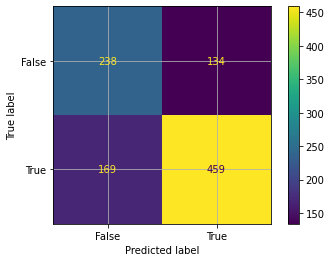

In [131]:
confusion_matrix = metrics.confusion_matrix(y_valid, predictions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.grid()
plt.show() 

In [133]:
print(classification_report(y_valid, predictions, target_names = ["legit", "dga"]))

              precision    recall  f1-score   support

       legit       0.58      0.64      0.61       372
         dga       0.77      0.73      0.75       628

    accuracy                           0.70      1000
   macro avg       0.68      0.69      0.68      1000
weighted avg       0.70      0.70      0.70      1000



In [136]:
clf = tree.DecisionTreeClassifier()  # clf means classifier
clf = clf.fit(X_train, y_train)

# Realizamos predicciones con las metricas de validación
predictions2 = clf.predict(X_valid)

In [138]:
# Get the results y_valid
# validation_confusion_matrix = confusion_matrix(target_val, predictions2)
# validation_recall_score = recall_score(target_val, predictions2, average=None)
# validation_precision_score = precision_score(target_val, predictions2, average=None)
# validation_f1_score = f1_score(target_val, predictions2, average=None)
# print("Matrix de confusión: ", validation_confusion_matrix)

print(metrics.accuracy_score(y_valid, predictions2))
print('Confusion Matrix\n', metrics.confusion_matrix(y_valid, predictions2))

0.651
Confusion Matrix
 [[218 154]
 [195 433]]


In [148]:
from sklearn.ensemble import ExtraTreesClassifier

rf2 = ExtraTreesClassifier(n_estimators = 100, random_state = 42)
rf2.fit(X_train, y_train)

ExtraTreesClassifier(random_state=42)

In [149]:
# Realizamos predicciones con las metricas de validación
predictions3 = rf2.predict(X_valid)

# Get the results y_valid
validation_confusion_matrix = confusion_matrix(y_valid, predictions3)
validation_recall_score = recall_score(y_valid, predictions3, average=None)
validation_precision_score = precision_score(y_valid, predictions3, average=None)
validation_f1_score = f1_score(y_valid, predictions3, average=None)
print(metrics.accuracy_score(y_valid, predictions3))
print("Matrix de confusión: ", validation_confusion_matrix)

0.685
Matrix de confusión:  [[255 141]
 [174 430]]


# ----------------------------------------------------------------------------------------------------------

In [153]:
df_copy = df.copy()

In [158]:
# Obtenemos F1
df_copy['length'] = df_copy['url'].str.len()

In [161]:
df_copy = getHostname(df_copy)
df_copy = SpecialCharacters(df_copy)
df_copy = Check4HTTPS(df_copy)
df_copy = ratioDigits(df_copy)

In [163]:
df_copy['status'] = df['status'].replace(['legitimate', 'phishing'], ['0', '1'])
df_copy.drop(['url'], axis=1, inplace=True)

In [165]:
profile = ProfileReport(df_copy, title="Detecting Pishing in URLs")
profile.to_file("Pishing.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [173]:
df_copy2 = df_copy[['shortest_word_host', 'phish_hints', 'ratio_intHyperlinks',
                    'ratio_extHyperlinks', 'ratio_extRedirection', 'ratio_extErrors', 'links_in_tags', 'ratio_intMedia', 
                    'ratio_extMedia', 'safe_anchor', 'page_rank', 'hostname_length', 'urlDigits_ratio', 
                    'hostnameDigits_ratio', 'ip', 'nb_www', 'tld_in_subdomain', 'nb_subdomains', 'prefix_suffix', 
                    'empty_title', 'domain_in_title', 'google_index', 'Special_Char_Count', 'status']]

In [164]:
df_copy

,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,...,dns_record,google_index,page_rank,status,length,hostname_length,Special_Char_Count,HTTPS,urlDigits_ratio,hostnameDigits_ratio
0,0,1,0,0,0,0,0,0,0,0,...,1,1,4,0,37,27,7,0,0.000000,0.0
1,1,0,0,0,0,0,0,0,0,0,...,0,1,2,1,77,31,7,0,0.220779,0.0
2,1,0,1,0,0,0,0,0,1,0,...,0,1,0,1,126,59,19,1,0.150794,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,18,19,5,0,0.000000,0.0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,6,0,55,23,10,0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,0,1,0,0,0,0,0,0,0,0,...,0,0,6,0,45,25,7,0,0.000000,0.0
11426,0,1,1,0,0,0,0,1,0,0,...,0,1,0,1,84,26,15,0,0.023810,0.0
11427,1,1,0,0,0,0,0,0,0,0,...,0,1,10,0,105,25,17,1,0.142857,0.0
11428,0,1,0,0,0,0,0,0,0,0,...,0,0,4,0,38,38,6,0,0.000000,0.0


In [170]:
df_copy2

,shortest_word_host,phish_hints,ratio_intHyperlinks,ratio_extHyperlinks,ratio_extRedirection,ratio_extErrors,links_in_tags,ratio_intMedia,ratio_extMedia,safe_anchor,...,hostnameDigits_ratio,ip,nb_www,tld_in_subdomain,nb_subdomains,prefix_suffix,empty_title,domain_in_title,google_index,Special_Char_Count
0,3,0,0.529412,0.470588,0.875000,0.500000,80.000000,100.000000,0.000000,0.000000,...,0.0,0,1,0,3,0,0,0,1,7
1,19,0,0.966667,0.033333,0.000000,0.000000,100.000000,80.000000,20.000000,100.000000,...,0.0,1,0,0,1,0,0,1,1,7
2,3,0,1.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,100.000000,...,0.0,1,0,1,3,1,0,1,1,19
3,5,0,0.973154,0.026846,0.250000,0.250000,100.000000,96.428571,3.571429,62.500000,...,0.0,0,0,0,2,0,0,1,0,5
4,3,0,0.470588,0.529412,0.537037,0.018519,76.470588,0.000000,100.000000,0.000000,...,0.0,0,1,0,2,0,0,0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,3,0,0.884422,0.115578,0.043478,0.173913,80.000000,21.052632,78.947368,0.000000,...,0.0,0,1,0,2,0,0,0,0,7
11426,3,0,1.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,...,0.0,0,1,0,3,0,0,1,1,15
11427,3,0,0.470588,0.529412,0.000000,0.000000,6.250000,0.000000,0.000000,80.000000,...,0.0,1,1,0,2,0,0,0,1,17
11428,3,0,0.375000,0.625000,0.050000,0.050000,16.666667,0.000000,100.000000,0.000000,...,0.0,0,1,0,2,0,0,1,0,6


In [171]:
df_copy2.drop_duplicates()

,shortest_word_host,phish_hints,ratio_intHyperlinks,ratio_extHyperlinks,ratio_extRedirection,ratio_extErrors,links_in_tags,ratio_intMedia,ratio_extMedia,safe_anchor,...,hostnameDigits_ratio,ip,nb_www,tld_in_subdomain,nb_subdomains,prefix_suffix,empty_title,domain_in_title,google_index,Special_Char_Count
0,3,0,0.529412,0.470588,0.875000,0.500000,80.000000,100.000000,0.000000,0.000000,...,0.0,0,1,0,3,0,0,0,1,7
1,19,0,0.966667,0.033333,0.000000,0.000000,100.000000,80.000000,20.000000,100.000000,...,0.0,1,0,0,1,0,0,1,1,7
2,3,0,1.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,100.000000,...,0.0,1,0,1,3,1,0,1,1,19
3,5,0,0.973154,0.026846,0.250000,0.250000,100.000000,96.428571,3.571429,62.500000,...,0.0,0,0,0,2,0,0,1,0,5
4,3,0,0.470588,0.529412,0.537037,0.018519,76.470588,0.000000,100.000000,0.000000,...,0.0,0,1,0,2,0,0,0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,3,0,0.884422,0.115578,0.043478,0.173913,80.000000,21.052632,78.947368,0.000000,...,0.0,0,1,0,2,0,0,0,0,7
11426,3,0,1.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,...,0.0,0,1,0,3,0,0,1,1,15
11427,3,0,0.470588,0.529412,0.000000,0.000000,6.250000,0.000000,0.000000,80.000000,...,0.0,1,1,0,2,0,0,0,1,17
11428,3,0,0.375000,0.625000,0.050000,0.050000,16.666667,0.000000,100.000000,0.000000,...,0.0,0,1,0,2,0,0,1,0,6


In [174]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df_copy2, target='status', 
                                                                            train_size=0.55, valid_size=0.15, test_size=0.3)

In [175]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [176]:
# Realizamos predicciones con las metricas de validación
predictions = rf.predict(X_valid)

# Get the results y_valid
validation_confusion_matrix = confusion_matrix(y_valid, predictions)
validation_recall_score = recall_score(y_valid, predictions, average=None)
validation_precision_score = precision_score(y_valid, predictions, average=None)
validation_f1_score = f1_score(y_valid, predictions, average=None)
print(metrics.accuracy_score(y_valid, predictions))
print("Matrix de confusión: ", validation_confusion_matrix)

0.9579929988331388
Matrix de confusión:  [[802  36]
 [ 36 840]]


In [177]:
clf = tree.DecisionTreeClassifier()  # clf means classifier
clf = clf.fit(X_train, y_train)

# Realizamos predicciones con las metricas de validación
predictions2 = clf.predict(X_valid)

In [178]:
# Get the results y_valid
validation_confusion_matrix = confusion_matrix(y_valid, predictions2)
validation_recall_score = recall_score(y_valid, predictions2, average=None)
validation_precision_score = precision_score(y_valid, predictions2, average=None)
validation_f1_score = f1_score(y_valid, predictions2, average=None)
print(metrics.accuracy_score(y_valid, predictions2))
print("Matrix de confusión: ", validation_confusion_matrix)

0.9311551925320887
Matrix de confusión:  [[780  58]
 [ 60 816]]


In [179]:
rf2 = ExtraTreesClassifier(n_estimators = 100, random_state = 42)
rf2.fit(X_train, y_train)

ExtraTreesClassifier(random_state=42)

In [181]:
# Realizamos predicciones con las metricas de validación
predictions3 = rf2.predict(X_valid)

# Get the results y_valid
validation_confusion_matrix = confusion_matrix(y_valid, predictions3)
validation_recall_score = recall_score(y_valid, predictions3, average=None)
validation_precision_score = precision_score(y_valid, predictions3, average=None)
validation_f1_score = f1_score(y_valid, predictions3, average=None)
print(metrics.accuracy_score(y_valid, predictions3))
print("Matrix de confusión: ", validation_confusion_matrix)

0.9498249708284714
Matrix de confusión:  [[798  40]
 [ 46 830]]
